<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов
**Заполните код в клетках и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1l3OtddjlKGGyl285bkzu4ulH5cXSnBdAkqR9VzB3Bgg/edit).**

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.2.2


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
model = Prophet(yearly_seasonality=True)
model.fit(train_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=30)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [10]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
378,2016-01-16,2947.105978,2947.105738,2947.106286,2136.272181,2826.945443,-460.372930,-460.372930,-460.372930,0.0,0.0,0.0,-860.395398,-860.395398,-860.395398,400.022468,400.022468,400.022468,2486.733048
379,2016-01-17,2950.114100,2950.113845,2950.114432,2290.675495,2974.655151,-302.858827,-302.858827,-302.858827,0.0,0.0,0.0,-720.108568,-720.108568,-720.108568,417.249742,417.249742,417.249742,2647.255273
380,2016-01-18,2953.122222,2953.121949,2953.122574,3296.197878,4047.076080,714.495735,714.495735,714.495735,0.0,0.0,0.0,282.578613,282.578613,282.578613,431.917121,431.917121,431.917121,3667.617956
381,2016-01-19,2956.130343,2956.130050,2956.130708,3584.767978,4323.652951,981.932544,981.932544,981.932544,0.0,0.0,0.0,538.020096,538.020096,538.020096,443.912448,443.912448,443.912448,3938.062887
382,2016-01-20,2959.138465,2959.138154,2959.138849,3476.134641,4207.500023,874.812508,874.812508,874.812508,0.0,0.0,0.0,421.650130,421.650130,421.650130,453.162377,453.162377,453.162377,3833.950972


In [11]:
round(forecast['yhat'][-1:])

382    3834.0
Name: yhat, dtype: float64

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [12]:
import numpy as np
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 38.42161608354381
MAE 713.7696174051705


**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

**Ответ:** MAPE 38.42

**Ответ:** MAE 713.76

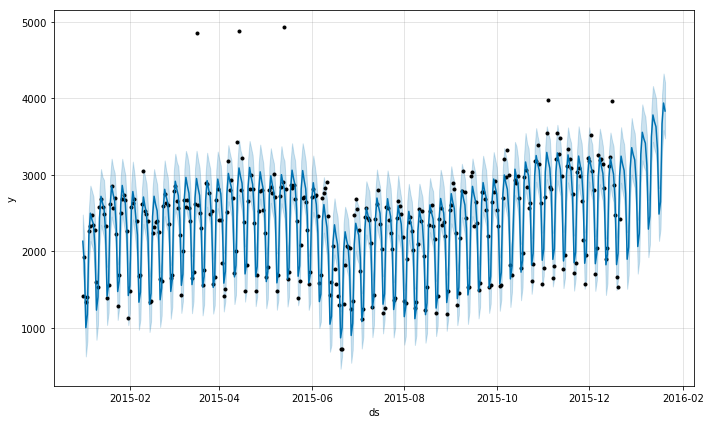

In [14]:
model.plot(forecast)

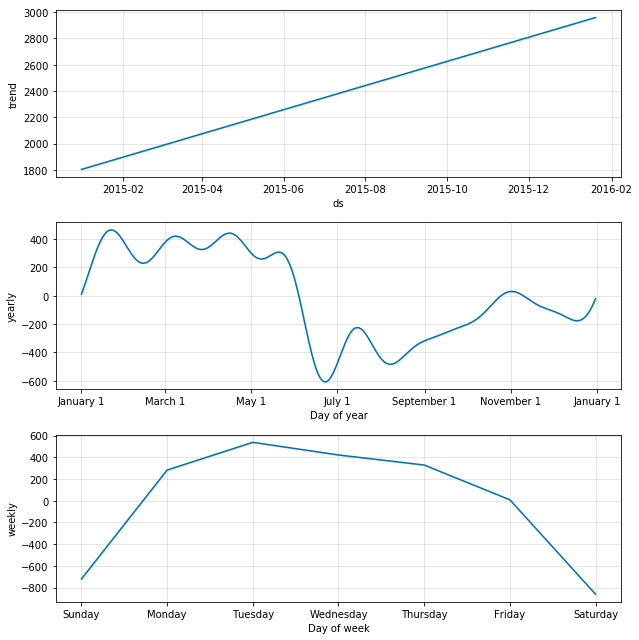

In [15]:
model.plot_components(forecast)

## Предсказываем с помощью ARIMA

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

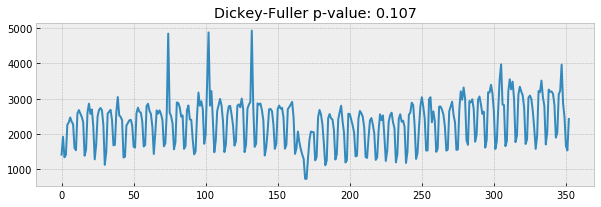

In [17]:
def plotProcess(x):
    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(x)[1], 3)))

plotProcess(train_df['y'].values)

Критерий Дики-Фуллера: p=0.107392


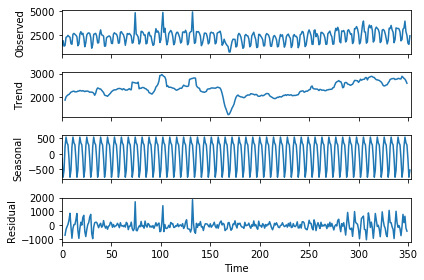

In [18]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

**Ответ:** Критерий Дики-Фуллера: p=0.107392,исходный ряд не стационарный

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [20]:
sarima=train_df.set_index('ds')
sarima.index = pd.to_datetime(sarima.index)

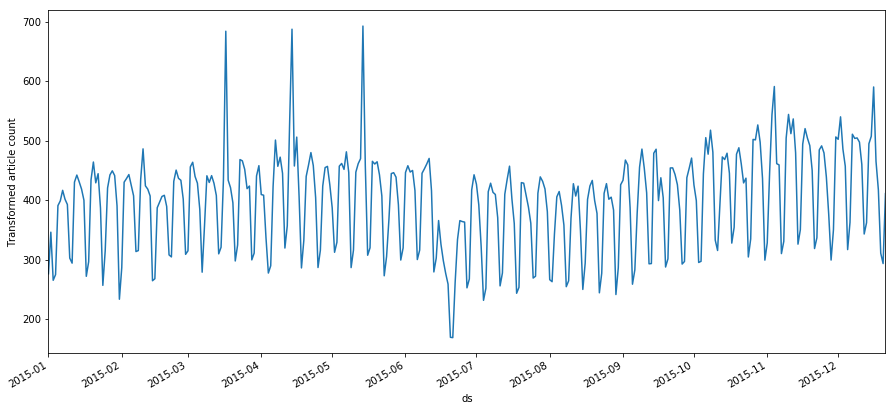

In [21]:
from scipy import stats

sarima['y_box'], lmbda = stats.boxcox(sarima['y'])#stats.boxcox([1 if x == 0 else x for x in sarima['y']])
plt.figure(figsize=(15,7))
sarima.y_box.plot()
plt.ylabel(u'Transformed article count')

In [22]:
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sarima['y'])[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.732841
Критерий Дики-Фуллера: p=0.107392


In [24]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
#sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();

In [25]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

Критерий Дики-Фуллера: p=0.000000


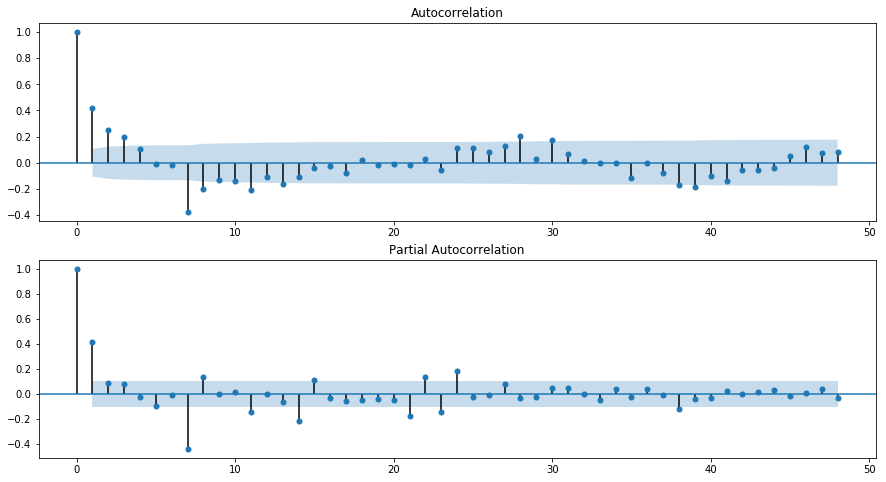

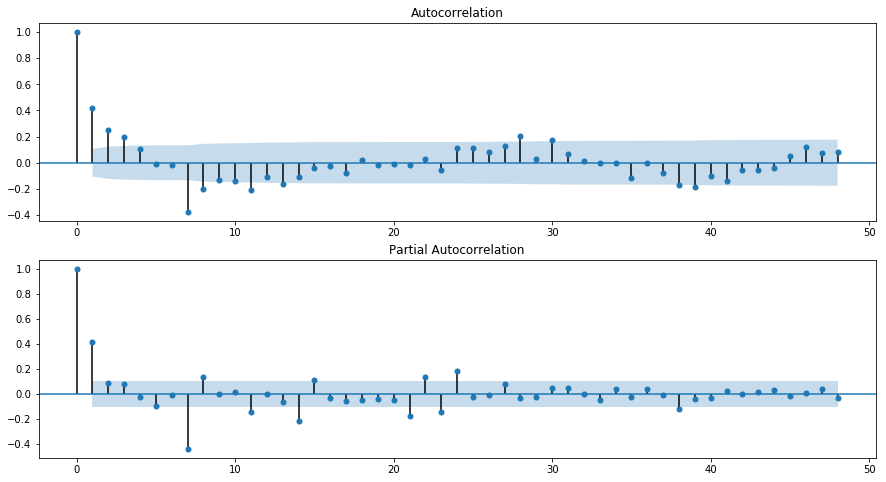

In [26]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)

In [35]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)


from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")

for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 4, 0)
(0, 0, 4, 1)
(0, 0, 5, 0)
(0, 0, 5, 1)
(0, 0, 6, 0)
(0, 0, 6, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 3, 0)
(0, 1, 3, 1)
(0, 1, 4, 0)
(0, 1, 4, 1)
(0, 1, 5, 0)
(0, 1, 5, 1)
(0, 1, 6, 0)
(0, 1, 6, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 2, 3, 0)
(0, 2, 3, 1)
(0, 2, 4, 0)
(0, 2, 4, 1)
(0, 2, 5, 0)
(0, 2, 5, 1)
(0, 2, 6, 0)
(0, 2, 6, 1)
(0, 3, 0, 0)
(0, 3, 0, 1)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 2, 0)
(0, 3, 2, 1)
(0, 3, 3, 0)
(0, 3, 3, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 3, 4, 0)
(0, 3, 4, 1)
(0, 3, 5, 0)
(0, 3, 5, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 3, 6, 0)
(0, 3, 6, 1)
(0, 4, 0, 0)
(0, 4, 0, 1)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 2, 0)
(0, 4, 2, 1)
(0, 4, 3, 0)
(0, 4, 3, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 4, 4, 0)
(0, 4, 4, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 4, 5, 0)
(0, 4, 5, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 4, 6, 0)
(0, 4, 6, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 0, 3, 0)
(1, 0, 3, 1)
(1, 0, 4, 0)
(1, 0, 4, 1)
(1, 0, 5, 0)
(1, 0, 5, 1)
(1, 0, 6, 0)
(1, 0, 6, 1)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 2, 0)
(1, 1, 2, 1)
(1, 1, 3, 0)
(1, 1, 3, 1)
(1, 1, 4, 0)
(1, 1, 4, 1)
(1, 1, 5, 0)
(1, 1, 5, 1)
(1, 1, 6, 0)
(1, 1, 6, 1)
(1, 2, 0, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 0, 1)
(1, 2, 1, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 1, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 2, 0)
(1, 2, 2, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 3, 0)
(1, 2, 3, 1)
(1, 2, 4, 0)
(1, 2, 4, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 5, 0)
(1, 2, 5, 1)
(1, 2, 6, 0)
(1, 2, 6, 1)
(1, 3, 0, 0)
wrong parameters: (1, 3, 0, 0)
(1, 3, 0, 1)
wrong parameters: (1, 3, 0, 1)
(1, 3, 1, 0)
wrong parameters: (1, 3, 1, 0)
(1, 3, 1, 1)
wrong parameters: (1, 3, 1, 1)
(1, 3, 2, 0)
wrong parameters: (1, 3, 2, 0)
(1, 3, 2, 1)
wrong parameters: (1, 3, 2, 1)
(1, 3, 3, 0)
wrong parameters: (1, 3, 3, 0)
(1, 3, 3, 1)
wrong parameters: (1, 3, 3, 1)
(1, 3, 4, 0)
wrong parameters: (1, 3, 4, 0)
(1, 3, 4, 1)
wrong parameters: (1, 3, 4, 1)
(1, 3, 5, 0)
wrong parameters: (1, 3, 5, 0)
(1, 3, 5, 1)
wrong parameters: (1, 3, 5, 1)
(1, 3, 6, 0)
wrong parameters: (1, 3, 6, 0)
(1, 3, 6, 1)
wrong parameters: (1, 3, 6, 1)
(1, 4, 0, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 0, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 1, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 1, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 2, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 2, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 3, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 3, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 4, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 4, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 5, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 5, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 6, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 6, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 0, 0, 0)
(2, 0, 0, 1)
(2, 0, 1, 0)
(2, 0, 1, 1)
(2, 0, 2, 0)
(2, 0, 2, 1)
(2, 0, 3, 0)
(2, 0, 3, 1)
(2, 0, 4, 0)
(2, 0, 4, 1)
(2, 0, 5, 0)
(2, 0, 5, 1)
(2, 0, 6, 0)
(2, 0, 6, 1)
(2, 1, 0, 0)
(2, 1, 0, 1)
(2, 1, 1, 0)
(2, 1, 1, 1)
(2, 1, 2, 0)
(2, 1, 2, 1)
(2, 1, 3, 0)
(2, 1, 3, 1)
(2, 1, 4, 0)
(2, 1, 4, 1)
(2, 1, 5, 0)
(2, 1, 5, 1)
(2, 1, 6, 0)
(2, 1, 6, 1)
(2, 2, 0, 0)


C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning:

invalid value encountered in sqrt



wrong parameters: (2, 2, 0, 0)
(2, 2, 0, 1)
wrong parameters: (2, 2, 0, 1)
(2, 2, 1, 0)
wrong parameters: (2, 2, 1, 0)
(2, 2, 1, 1)
wrong parameters: (2, 2, 1, 1)
(2, 2, 2, 0)
wrong parameters: (2, 2, 2, 0)
(2, 2, 2, 1)
wrong parameters: (2, 2, 2, 1)
(2, 2, 3, 0)


LinAlgError: Singular matrix

In [36]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 7)   Log Likelihood               -1770.957
Date:                           Mon, 25 Jun 2018   AIC                           3555.913
Time:                                   00:33:23   BIC                           3582.979
Sample:                               01-01-1970   HQIC                          3566.683
                                    - 01-01-1970                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4896      0.033     14.618      0.000       0.424       0.555
ma.L1         -0.9989      0.079    -12.692